In [1]:
import torch
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# preproccess the data

In [2]:
# Function to preprocess image
def preprocess_image(image_path, target_size=(300, 300)):
    img = cv2.imread(image_path)
    # gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, target_size)
    # img_flattened = img_resized.flatten()
    img_normalized = img_resized.astype("float32") / 255.0
    return img_normalized

def preprocess_data():
    # Load and preprocess train and test data
    train_dir = 'train'
    test_dir = 'test'

    train_filepaths = []
    train_labels = []
    for label in os.listdir(train_dir):
        label_dir = os.path.join(train_dir, label)
        for filename in os.listdir(label_dir):
            filepath = os.path.join(label_dir, filename)
            train_filepaths.append(filepath)
            train_labels.append(label)

    test_filepaths = []
    test_labels = []
    for label in os.listdir(test_dir):
        label_dir = os.path.join(test_dir, label)
        for filename in os.listdir(label_dir):
            filepath = os.path.join(label_dir, filename)
            test_filepaths.append(filepath)
            test_labels.append(label)

    target_size = (228, 228)
    x_train = np.array([preprocess_image(filepath, target_size) for filepath in train_filepaths])
    y_train = np.array(train_labels)
    x_test = np.array([preprocess_image(filepath, target_size) for filepath in test_filepaths])
    y_test = np.array(test_labels)

    # Convert labels to numerical values
    label_to_index = {label: i for i, label in enumerate(np.unique(y_train))}
    y_train = np.array([label_to_index[label] for label in y_train])
    y_test = np.array([label_to_index[label] for label in y_test])

#     # Convert NumPy arrays to PyTorch tensors
#     x_train_tensor = torch.from_numpy(x_train)
#     y_train_tensor = torch.from_numpy(y_train).long()
#     x_test_tensor = torch.from_numpy(x_test)
#     y_test_tensor = torch.from_numpy(y_test).long()

    return x_train, y_train, x_test, y_test, train_filepaths, train_labels, test_filepaths, test_labels


In [3]:
x_train, y_train, x_test, y_test, train_filepaths, train_labels, test_filepaths, test_labels = preprocess_data()

In [4]:
trainData =pd.DataFrame({'filepath':train_filepaths,'label':train_labels}) 
trainData.head()

,filepath,label
0,train\Covid\01.jpeg,Covid
1,train\Covid\010.png,Covid
2,train\Covid\012.jpeg,Covid
3,train\Covid\015.jpg,Covid
4,train\Covid\019.png,Covid


In [5]:
testData =pd.DataFrame({'filepath':test_filepaths,'label':test_labels}) 
testData.head()

,filepath,label
0,test\Covid\0100.jpeg,Covid
1,test\Covid\0102.jpeg,Covid
2,test\Covid\0105.png,Covid
3,test\Covid\0106.jpeg,Covid
4,test\Covid\0108.jpeg,Covid


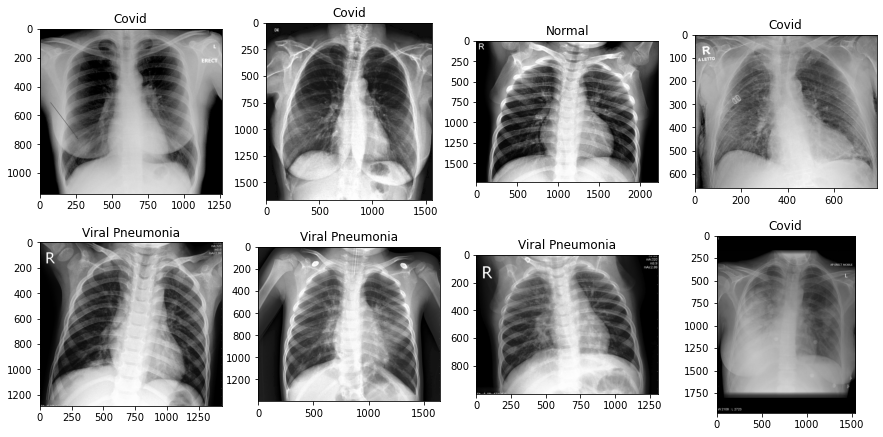

In [6]:
# Shuffle indices
shuffled_indices = list(range(len(trainData)))
random.shuffle(shuffled_indices)

# Shuffle data based on shuffled indices
shuffled_train_data = trainData.iloc[shuffled_indices].reset_index(drop=True)

# Show some samples from the shuffled train dataset
fig = plt.figure(figsize=(15, 15))
for i in range(8):
    fig.add_subplot(4, 4, i + 1).set_title(shuffled_train_data['label'][i])
    img = cv2.imread(shuffled_train_data['filepath'][i])
    plt.imshow(img)

plt.show()

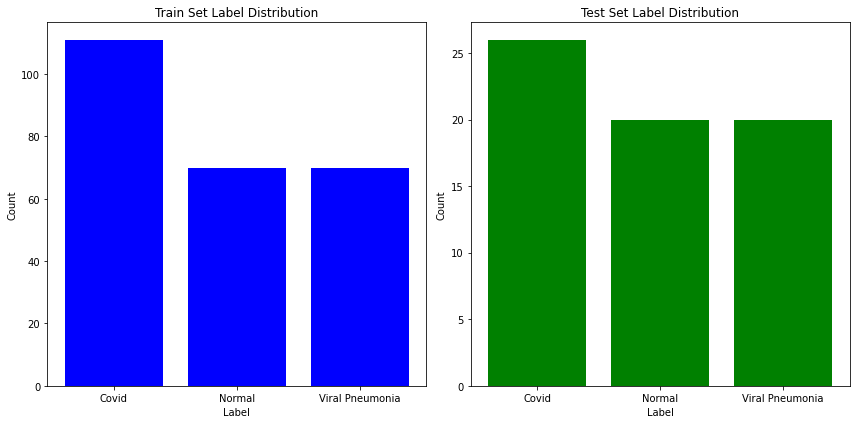

In [7]:
import matplotlib.pyplot as plt

# Count occurrences of each label in the train set
train_label_counts = trainData['label'].value_counts()

# Count occurrences of each label in the test set
test_label_counts = testData['label'].value_counts()

# Plot histograms
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram for train set
axs[0].bar(train_label_counts.index, train_label_counts.values, color='blue')
axs[0].set_title('Train Set Label Distribution')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Count')

# Plot histogram for test set
axs[1].bar(test_label_counts.index, test_label_counts.values, color='green')
axs[1].set_title('Test Set Label Distribution')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


## the data has more indices of covid, but got enough samples from each label.

### lets split the train set to train and validation set. then print the amount of the samples in each set.

In [8]:
# first create validation set
#split the train
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Convert categorical labels to one-hot encoded format
y_train_onehot = tf.keras.utils.to_categorical(y_train, 3)
y_val_onehot = tf.keras.utils.to_categorical(y_val, 3)

# Convert it also for the test set
y_test_onehot = tf.keras.utils.to_categorical(y_test, 3)


# Print the length of train, validation and test sets
print("Num of samples in train set: ", len(y_train_onehot))
print("Num of samples in validation set: ", len(y_val_onehot))
print("Num of samples in test set: ", len(y_test_onehot))

Num of samples in train set:  200
Num of samples in validation set:  51
Num of samples in test set:  66


## lets start with simple softmax model

In [9]:
# Define a simple neural network model with softmax activation
class SoftmaxModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(SoftmaxModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten(input_shape=(300, 300))  # Flatten input images
        self.dense = tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer with softmax activation

    def call(self, x):
        x = self.flatten(x)
        return self.dense(x)

# Create an instance of the softmax model
num_classes = 3  # Number of classes
model = SoftmaxModel(num_classes)
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Compile the model with categorical cross-entropy loss
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train_onehot, epochs=50, batch_size=32, validation_data=(x_val, y_val_onehot))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test_onehot)

print("Test Accuracy:", test_acc)

# Predictions on the test set
y_pred_prob = model.predict(x_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)

Epoch 1/50
7/7 [==============================] - 1s 36ms/step - loss: 42.7843 - accuracy: 0.3700 - val_loss: 59.3521 - val_accuracy: 0.4510
Epoch 2/50
7/7 [==============================] - 0s 15ms/step - loss: 31.4418 - accuracy: 0.4850 - val_loss: 11.2023 - val_accuracy: 0.6471
Epoch 3/50
7/7 [==============================] - 0s 14ms/step - loss: 11.0136 - accuracy: 0.6900 - val_loss: 6.1791 - val_accuracy: 0.8039
Epoch 4/50
7/7 [==============================] - 0s 14ms/step - loss: 5.4120 - accuracy: 0.7950 - val_loss: 5.4967 - val_accuracy: 0.8039
Epoch 5/50
7/7 [==============================] - 0s 14ms/step - loss: 3.7057 - accuracy: 0.8400 - val_loss: 5.7263 - val_accuracy: 0.8627
Epoch 6/50
7/7 [==============================] - 0s 14ms/step - loss: 3.0735 - accuracy: 0.8600 - val_loss: 4.4248 - val_accuracy: 0.8824
Epoch 7/50
7/7 [==============================] - 0s 15ms/step - loss: 2.5421 - accuracy: 0.8950 - val_loss: 7.4082 - val_accuracy: 0.8039
Epoch 8/50
7/7 [======

## simple NN model

In [10]:
import tensorflow as tf

# Define a simple neural network model
class SimpleNN(tf.keras.Model):
    def __init__(self, num_classes):
        super(SimpleNN, self).__init__()
        self.flatten = tf.keras.layers.Flatten(input_shape=(300, 300, 3))  # Flatten input images
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')  # First dense layer with ReLU activation
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')  # Second dense layer with ReLU activation
        self.dense3 = tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer with softmax activation

    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

# Create an instance of the simple neural network model
num_classes = 3  # Number of classes
model = SimpleNN(num_classes)

# Define learning rate
learning_rate = 0.001

# Create an optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Compile the model with categorical cross-entropy loss
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [11]:
# Train the model
history = model.fit(x_train, y_train_onehot, epochs=50, batch_size=32, validation_data=(x_val, y_val_onehot))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test_onehot)

print("Test Accuracy:", test_acc)

# Predictions on the test set
y_pred_prob = model.predict(x_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)

Epoch 1/50
7/7 [==============================] - 2s 165ms/step - loss: 34.7600 - accuracy: 0.4150 - val_loss: 25.4774 - val_accuracy: 0.4510
Epoch 2/50
7/7 [==============================] - 1s 140ms/step - loss: 7.0573 - accuracy: 0.6850 - val_loss: 2.3462 - val_accuracy: 0.8627
Epoch 3/50
7/7 [==============================] - 1s 145ms/step - loss: 1.9904 - accuracy: 0.8250 - val_loss: 2.3124 - val_accuracy: 0.8431
Epoch 4/50
7/7 [==============================] - 1s 145ms/step - loss: 0.9104 - accuracy: 0.8500 - val_loss: 2.1785 - val_accuracy: 0.8824
Epoch 5/50
7/7 [==============================] - 1s 146ms/step - loss: 4.0520 - accuracy: 0.7100 - val_loss: 6.1970 - val_accuracy: 0.6667
Epoch 6/50
7/7 [==============================] - 1s 149ms/step - loss: 2.9059 - accuracy: 0.7950 - val_loss: 2.4515 - val_accuracy: 0.8824
Epoch 7/50
7/7 [==============================] - 1s 147ms/step - loss: 1.1213 - accuracy: 0.9150 - val_loss: 3.0992 - val_accuracy: 0.8431
Epoch 8/50
7/7 [==

# CNN model

In [34]:
class SimpleCNN(tf.keras.Model):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3))  # Convolutional layer with ReLU activation
        self.pool1 = tf.keras.layers.MaxPooling2D((2, 2))  # Max pooling layer
        self.conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')  # Convolutional layer with ReLU activation
        self.pool2 = tf.keras.layers.MaxPooling2D((2, 2))  # Max pooling layer
        self.dropout1 = tf.keras.layers.Dropout(0.25)  # Dropout layer with dropout rate of 25%
        self.flatten = tf.keras.layers.Flatten()  # Flatten layer
        self.dense1 = tf.keras.layers.Dense(516, activation='relu')  # Dense layer with ReLU activation
        self.dropout2 = tf.keras.layers.Dropout(0.4)  # Dropout layer with dropout rate of 40%
        self.dense2 = tf.keras.layers.Dense(256, activation='relu')  # Dense layer with ReLU activation
        self.dense3 = tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer with softmax activation

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout2(x)
        x = self.dense2(x)
        return self.dense3(x)

# Create an instance of the simple neural network model
num_classes = 3  # Number of classes
model = SimpleNN(num_classes)

# Define learning rate
learning_rate = 0.000001

# Create an optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Compile the model with categorical cross-entropy loss
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [35]:

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [36]:
# Train the model
history = model.fit(x_train, y_train_onehot, epochs=100, batch_size=32, validation_data=(x_val, y_val_onehot))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test_onehot)

print("Test Accuracy:", test_acc)

# Predictions on the test set
y_pred_prob = model.predict(x_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)

Epoch 1/100
7/7 [==============================] - 1s 149ms/step - loss: 1.0496 - accuracy: 0.3900 - val_loss: 0.9111 - val_accuracy: 0.6078
Epoch 2/100
7/7 [==============================] - 1s 138ms/step - loss: 0.8520 - accuracy: 0.6600 - val_loss: 0.7746 - val_accuracy: 0.7647
Epoch 3/100
7/7 [==============================] - 1s 135ms/step - loss: 0.7204 - accuracy: 0.8150 - val_loss: 0.6754 - val_accuracy: 0.8235
Epoch 4/100
7/7 [==============================] - 1s 136ms/step - loss: 0.6266 - accuracy: 0.8650 - val_loss: 0.6009 - val_accuracy: 0.8235
Epoch 5/100
7/7 [==============================] - 1s 139ms/step - loss: 0.5594 - accuracy: 0.8900 - val_loss: 0.5389 - val_accuracy: 0.8627
Epoch 6/100
7/7 [==============================] - 1s 137ms/step - loss: 0.5039 - accuracy: 0.9050 - val_loss: 0.4871 - val_accuracy: 0.9020
Epoch 7/100
7/7 [==============================] - 1s 137ms/step - loss: 0.4507 - accuracy: 0.9150 - val_loss: 0.4639 - val_accuracy: 0.8431
Epoch 8/100
7

Epoch 59/100
7/7 [==============================] - 1s 144ms/step - loss: 0.1048 - accuracy: 0.9800 - val_loss: 0.2543 - val_accuracy: 0.9216
Epoch 60/100
7/7 [==============================] - 1s 144ms/step - loss: 0.1015 - accuracy: 0.9800 - val_loss: 0.2610 - val_accuracy: 0.9216
Epoch 61/100
7/7 [==============================] - 1s 142ms/step - loss: 0.0989 - accuracy: 0.9800 - val_loss: 0.2685 - val_accuracy: 0.9216
Epoch 62/100
7/7 [==============================] - 1s 140ms/step - loss: 0.0999 - accuracy: 0.9800 - val_loss: 0.2682 - val_accuracy: 0.9020
Epoch 63/100
7/7 [==============================] - 1s 143ms/step - loss: 0.0985 - accuracy: 0.9800 - val_loss: 0.2674 - val_accuracy: 0.9020
Epoch 64/100
7/7 [==============================] - 1s 138ms/step - loss: 0.1003 - accuracy: 0.9850 - val_loss: 0.2600 - val_accuracy: 0.9216
Epoch 65/100
7/7 [==============================] - 1s 139ms/step - loss: 0.0944 - accuracy: 0.9850 - val_loss: 0.2676 - val_accuracy: 0.9216
Epoch 